In [30]:
#authors: Fidel Ngo, Jamia Jackson, Rene Lisasi
#Fraud Detection
#Machine Learning

In [31]:
import pandas as pd
import numpy as np
import time
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

In [32]:
def get_data(filename):
    df = pd.read_csv(filename)
    x = df.drop(columns=['merchant','first','last','gender','street','city','state','zip','job','dob','trans_num','unix_time','trans_date_trans_time','cc_num'])
    # y = df['is_fraud']
    dataset=x
    # dataset = np.column_stack((x, y))
    #np.random.shuffle(dataset)
    # Split data
    train_size = int(0.7 * len(dataset))
    train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
    #features
    train_dataset=np.delete(train_dataset,0,axis=1)
    test_dataset=np.delete(test_dataset,0,axis=1)
    #targets
    train_target=train_dataset[:,7]
    test_target=test_dataset[:,7]

    train_dataset=np.delete(train_dataset,7,axis=1)
    test_dataset=np.delete(test_dataset,7,axis=1)

    return train_dataset, test_dataset, train_target, test_target

#output get_data
#train_sample,test_sample,train_target,test_target=get_data('fraudTrain_shuffled.csv')
#output get_data
train_sample,test_sample,train_target,test_target=get_data('fraudTrain_shuffled.csv')

scaler = StandardScaler()

train_sample_scaled = scaler.fit_transform(train_sample)
test_sample_scaled = scaler.transform(test_sample)

# reshape so it can match the input shape of the model
X_train_reshaped = np.reshape(train_sample_scaled, (train_sample_scaled.shape[0], 1, train_sample_scaled.shape[1]))
X_test_reshaped = np.reshape(test_sample_scaled, (test_sample_scaled.shape[0], 1, test_sample_scaled.shape[1]))


Feed Forward Neural Network

In [57]:
# Feedforward Neural Network
class FNN():
  # this method is a constructor and is used to create an instance of the feedforward neural network model containing the training data
  # parameters
  # learning_rate: this contains a float which is used to change how big of a jump the data will make
  # epoch: this contains a integer which is used to repeat the training epoch times
  # x: this contains the training dataset examples
  # y: this contains the training dataset answers
  def __init__(self, learning_rate, epoch, x, y):
    self.learning_rate = learning_rate
    self.epoch = epoch
    self.x = x
    self.y = y
    self.number_data, self.number_feature = x.shape
    self.input_weights = np.zeros((self.number_feature, 4))
    self.bias = 1
    self.bias_hidden = 1
    self.bias_output = 1
    self.hidden_weights = np.zeros(4)
    self.hidden_weights2 = np.zeros((4, 4))
    self.TP = 0
    self.FP = 0
    self.TN = 0
    self.FN = 0

  # this method is used for back propagation
  # parameters
  # input_hidden2: this contains an array that contains the input to hidden values but with relu applied to it
  # hidden2_hidden: this contains an array that contains the hidden to hidden values but with relu applied to it
  # output_output: this contains an array that contains the hidden to output values but with sigmoid applied to it
  def backward_pass(self, input_hidden2, hidden2_hidden,hidden_output):
    # Calculate errors
    # x
    output_error = hidden_output - self.y
    # x by 4
    hidden_error = np.outer(output_error, self.hidden_weights)
    # x by 4
    hidden_error2 = np.dot(hidden_error, self.hidden_weights2)

    # Calculating gradients. x by 4
    output_weights_gradient = (1/self.number_data) * np.dot(hidden2_hidden.T, output_error)
    output_grad_bias = (1/self.number_data) * np.sum(output_error)

    # x by 4
    hidden_weights_gradient = (1/self.number_data) * np.dot(input_hidden2.T, hidden_error)
    hidden_grad_bias = (1/self.number_data) * np.sum(hidden_error)

    # 4 by features
    hidden_weights_gradient2 = (1/self.number_data) * np.dot(self.x.T, hidden_error2)
    hidden_grad_bias2 = (1/self.number_data) * np.sum(hidden_error2)

    # Updating weights and biases
    self.hidden_weights -= self.learning_rate * output_weights_gradient
    self.bias_output -= self.learning_rate * output_grad_bias

    self.hidden_weights2 -= self.learning_rate * hidden_weights_gradient
    self.bias_hidden -= self.learning_rate * hidden_grad_bias

    self.input_weights -= self.learning_rate * hidden_weights_gradient2
    self.bias -= self.learning_rate * hidden_grad_bias2


  # trains the model
  def fit(self):
    for p in range(self.epoch):

      # input to hidden. x by 4
      hidden_input = np.dot(self.x, self.input_weights) + self.bias
      # x by 4
      relu_activation = np.maximum(0, hidden_input)

      # hidden2 to hidden. x by 4
      hidden_input2 = np.dot(relu_activation, self.hidden_weights2) + self.bias_hidden
      # x by 4
      relu_activation2 = 1 / (1 + np.exp(-hidden_input2))

      # hidden to output using sigmoid since it is a binary classification. x
      output_hidden = np.dot(relu_activation2, self.hidden_weights) + self.bias_output
      # x
      Sigmoid = 1 / (1 + np.exp(-output_hidden))
      # gradiants
      self.backward_pass(relu_activation, relu_activation2, Sigmoid)


  # finds the accuracy with the testing dataset
  # parameters
  # x_test: contains the testing dataset examples
  # y_test: contains the testing dataset answers
  def accuracy(self, x_test, y_test):
    # calculate the outputs
    hidden_input = np.dot(x_test, self.input_weights) + self.bias
    relu_activation = np.maximum(0, hidden_input)

    # hidden2 to hidden. x by 4
    hidden_input2 = np.dot(relu_activation, self.hidden_weights2) + self.bias_hidden
    # x by 4
    relu_activation2 = 1 / (1 + np.exp(-hidden_input2))

    # hidden to output
    output_hidden = np.dot(relu_activation2, self.hidden_weights) + self.bias_output
    Sigmoid = 1 / (1 + np.exp(-output_hidden))

    Is_Fraud = 0
    for i in range(len(y_test)):
      if y_test[i] == 1:
        Is_Fraud += 1

    print(Is_Fraud)
    accuracy = 0
    # finds accuracy
    for i in range(len(Sigmoid)):
      # uses the threshold to determine if it is 1 or 0
      if Sigmoid[i] > .5:
        # checks if the guess was correct, if it was increment by 1
        if y_test[i] == 1:
          accuracy += 1
          self.TP += 1
        else:
          self.FP += 1
      else:
        # checks if the guess was correct, if it was increment by 1
        if y_test[i] == 0:
          accuracy += 1
          self.TN += 1
        else:
          self.FN += 1
    f1 = self.TP / (self.TP + ((1/2) * (self.FP + self.FN)))
    accuracy=(accuracy / len(y_test)) * 100, f1
    # returns the percentage
    return accuracy

  def confuse_ff(self, title):
    #get predictions
    # predict=model.predict(test_features)
    labels = ["1", "0"]
    #build confusion matrix grid
    cm = np.array([[self.TP, self.FP],[self.FN, self.TN]])
    #represent the matrix on a plane
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    #plot the plane
    cmd.plot(cmap=plt.cm.Blues)
    cmd.ax_.set_title(f'{title} Confusion Matrix')
    plt.show()

-----------------------------------FNN-----------------------------------
1816
Accuracy: (72.47502774694784, 0.6325925925925926)


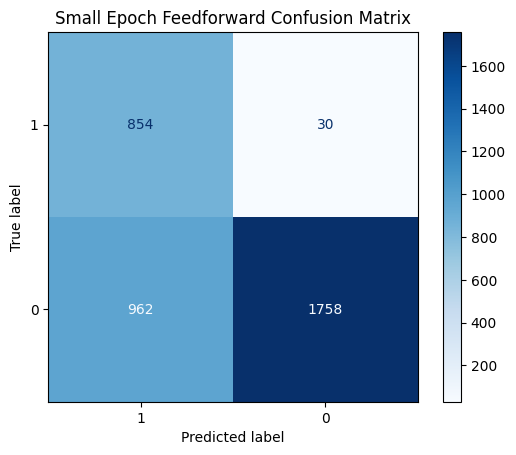

In [58]:
scaler = StandardScaler()

#output get_data
train_sample,test_sample,train_target,test_target=get_data('fraudTrain_shuffled.csv')

train_sample_scaled = scaler.fit_transform(train_sample)
test_sample_scaled = scaler.transform(test_sample)

# Feedforward Neural Networks running
print("-----------------------------------FNN-----------------------------------")
Feedforward_Neural_Network = FNN(0.01, 1000, train_sample_scaled, train_target)
Feedforward_Neural_Network.fit()
accuracy=Feedforward_Neural_Network.accuracy(test_sample_scaled, test_target)
print("Accuracy:",accuracy)
Feedforward_Neural_Network.confuse_ff('Small Epoch Feedforward')

In [60]:
# this method will save the weights of the model into a python file
# def saveWeights(self):
#     # this is a data type that stores key pair values so it stores w1 with the w1 weights
#     save = {
#         "w1": self.w1,
#         "w2": self.w2
#     }

#     # opens the json file in write mode and closes it when finished
#     with open("save.json", "w") as f:
#         # stores save in the json file
#         json.dump(save, f)


# # this method will load the weights of the model into the code
# def loadWeights(self):
#     # opens the json file in read mode and closes it when finished
#     with open("save.json", "r") as f:
#         # loads what is stored in the json file into the save
#         save = json.load(f)
#         # set the weights stored in save
#         self.w1 = save["w1"]
#         self.w2 = save["w2"]
def confuse(test_features,test_target,title):
    #get predictions
    predict=model.predict(test_features)
    y_pred = np.where(predict > 0.5, 1, 0).flatten()
    y_test = test_target
    labels = ["1", "0"]
    #build confusion matrix grid
    cm = confusion_matrix(y_test, y_pred)
    #represent the matrix on a plane
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    #plot the plane
    cmd.plot(cmap=plt.cm.Blues)
    cmd.ax_.set_title(f'{title} Confusion Matrix')
    plt.show()

def confuse_without_predict(test_features,test_target,title):
    y_pred = np.where(test_features > 0.5, 1, 0).flatten()
    y_test = test_target
    labels = ["1", "0"]
    #build confusion matrix grid
    cm = confusion_matrix(y_test, y_pred)
    #represent the matrix on a plane
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    #plot the plane
    cmd.plot(cmap=plt.cm.Blues)
    cmd.ax_.set_title(f'{title} Confusion Matrix')
    plt.show()

LSTM

In [61]:
# creates the model
model = Sequential()
model.add(LSTM(4))
model.add(Dense(1))

# compiles the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# trains the model
history = model.fit(X_train_reshaped, train_target, epochs=10, verbose=2,batch_size=1000)

# evaluates the model
loss = model.evaluate(X_test_reshaped, test_target)

Epoch 1/10
9/9 - 2s - loss: 0.5378 - accuracy: 0.4948 - 2s/epoch - 207ms/step
Epoch 2/10
9/9 - 0s - loss: 0.5113 - accuracy: 0.4952 - 18ms/epoch - 2ms/step
Epoch 3/10
9/9 - 0s - loss: 0.4863 - accuracy: 0.4939 - 19ms/epoch - 2ms/step
Epoch 4/10
9/9 - 0s - loss: 0.4631 - accuracy: 0.4937 - 19ms/epoch - 2ms/step
Epoch 5/10
9/9 - 0s - loss: 0.4414 - accuracy: 0.4931 - 19ms/epoch - 2ms/step
Epoch 6/10
9/9 - 0s - loss: 0.4213 - accuracy: 0.4950 - 20ms/epoch - 2ms/step
Epoch 7/10
9/9 - 0s - loss: 0.4025 - accuracy: 0.4966 - 20ms/epoch - 2ms/step
Epoch 8/10
9/9 - 0s - loss: 0.3847 - accuracy: 0.4994 - 18ms/epoch - 2ms/step
Epoch 9/10
9/9 - 0s - loss: 0.3681 - accuracy: 0.5018 - 20ms/epoch - 2ms/step
Epoch 10/10
9/9 - 0s - loss: 0.3525 - accuracy: 0.5065 - 18ms/epoch - 2ms/step
113/113 [==============================] - 0s 1ms/step - loss: 0.3520 - accuracy: 0.4892


113/113 [==============================] - 0s 982us/step


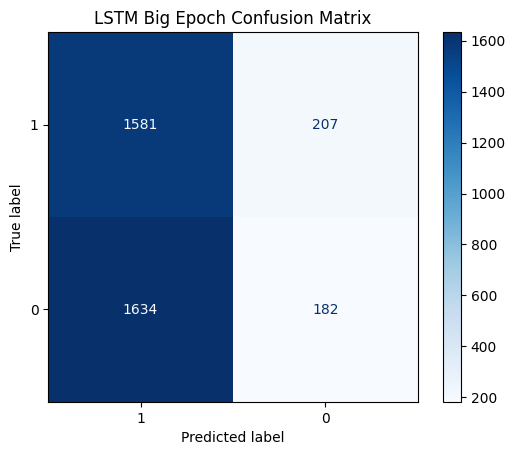

In [62]:
#lstm prediction
lstm_pred=model.predict(X_test_reshaped)
confuse_without_predict(lstm_pred,test_target,'LSTM Big Epoch')

RANDOM FOREST

In [63]:
scaler = StandardScaler()
train_sample_scaled = scaler.fit_transform(train_sample)
test_sample_scaled = scaler.transform(test_sample)

Accuracy: 95.53274139844618
F1_Score: 0.9553216317532697


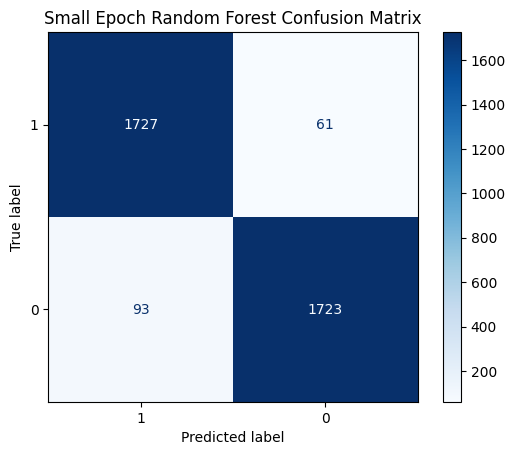

In [68]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_sample_scaled, train_target)
rf_predictions = rf.predict(test_sample_scaled)
threshold = 0.5
y_pred = [1 if pred >= threshold else 0 for pred in rf_predictions]
accuracy = 0
# finds accuracy
for i in range(len(y_pred)):
  # uses the threshold to determine if it is 1 or 0
  if y_pred[i] > .5:
    # checks if the guess was correct, if it was increment by 1
    if test_target[i] == 1:
      accuracy += 1
  else:
    # checks if the guess was correct, if it was increment by 1
    if test_target[i] == 0:
      accuracy += 1

accuracy = (accuracy / len(test_target)) * 100

print("Accuracy:", accuracy)

from sklearn.metrics import f1_score
import tensorflow as tf
# y_pred = tf.argmax(rf.predict(test_sample_scaled), axis=1)
print("F1_Score:",f1_score(test_target, y_pred, average='macro'))

confuse_without_predict(rf_predictions,test_target,"Small Epoch Random Forest")

CNN+LSTM

In [69]:
class PrintShape(tf.keras.layers.Layer):
  def call(self,inputs):
    print(inputs.shape)
    return inputs

data = pd.read_csv('fraudTrain_shuffled.csv')
data = pd.DataFrame(data)
y = data['is_fraud']
x = data.drop(columns=['is_fraud','index','merchant','first','last','gender','street','city','state','zip','job','dob','trans_num','unix_time','trans_date_trans_time','cc_num'])
print(x.columns)
features = x.values
labels = y.values
print(features[0],'label',labels[0])

trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(features, labels, test_size=0.3, random_state=42,shuffle=True)

q, x = trainFeatures.shape
print('trainfeatures',q,x)
scaler = StandardScaler()
trainFeatures = scaler.fit_transform(trainFeatures)
testFeatures = scaler.fit_transform(testFeatures)


trainFeatures = trainFeatures.reshape(trainFeatures.shape[0], trainFeatures.shape[1], 1)
testFeatures = testFeatures.reshape(testFeatures.shape[0], testFeatures.shape[1], 1)

q,x = features.shape
print(trainFeatures.shape, testFeatures.shape, trainLabels.shape, testLabels.shape)
print(x)

model = models.Sequential([
                           layers.BatchNormalization(),
                           layers.Conv1D(filters=16, kernel_size=3, activation ='relu',input_shape=(x,1)),
                           #PrintShape(),
                           layers.BatchNormalization(),
                           layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
                           #PrintShape(),
                           layers.BatchNormalization(),
                           layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
                           #PrintShape(),
                           layers.BatchNormalization(),
                           layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
                           layers.BatchNormalization(),
                           #PrintShape(),
                           layers.LSTM(32,return_sequences=True),
                           #PrintShape(),
                           layers.LSTM(32,return_sequences=True),
                           #PrintShape(),
                           layers.LSTM(32),
                           #PrintShape(),
                           layers.Dense(64,activation='relu'),
                           #PrintShape(),
                           layers.Dense(1,activation='sigmoid')
                           #PrintShape(),
                           ])

Index(['category', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
       'Unnamed: 23'],
      dtype='object')
[ 1.2000000e+01  9.8884000e+02  3.6024400e+01 -9.0928800e+01
  7.1550000e+03  3.5399805e+01 -9.1064403e+01  4.7067373e-01] label 1
trainfeatures 8408 8
(8408, 8, 1) (3604, 8, 1) (8408,) (3604,)
8


TRAIN CNN+LSTM

In [70]:
model.compile(optimizer=AdamW(learning_rate=0.001,weight_decay=0.005),loss='mse', metrics=['accuracy'])
history = model.fit(x=trainFeatures, y=trainLabels, batch_size=1000, verbose=1, epochs=10)

Epoch 1/10
9/9 [==============================] - 7s 46ms/step - loss: 0.2475 - accuracy: 0.6546
Epoch 2/10
9/9 [==============================] - 0s 46ms/step - loss: 0.2341 - accuracy: 0.7556
Epoch 3/10
9/9 [==============================] - 0s 46ms/step - loss: 0.2002 - accuracy: 0.7889
Epoch 4/10
9/9 [==============================] - 0s 46ms/step - loss: 0.1490 - accuracy: 0.8312
Epoch 5/10
9/9 [==============================] - 0s 47ms/step - loss: 0.1231 - accuracy: 0.8501
Epoch 6/10
9/9 [==============================] - 0s 46ms/step - loss: 0.1163 - accuracy: 0.8561
Epoch 7/10
9/9 [==============================] - 0s 47ms/step - loss: 0.1126 - accuracy: 0.8589
Epoch 8/10
9/9 [==============================] - 0s 47ms/step - loss: 0.1104 - accuracy: 0.8625
Epoch 9/10
9/9 [==============================] - 0s 46ms/step - loss: 0.1089 - accuracy: 0.8639
Epoch 10/10
9/9 [==============================] - 0s 46ms/step - loss: 0.1079 - accuracy: 0.8654


EVALUATE CNN+LSTM

113/113 [==============================] - 1s 2ms/step - loss: 0.2167 - accuracy: 0.5863
test loss, test accuracy [0.21667499840259552, 0.5862929821014404]
113/113 [==============================] - 1s 2ms/step
F1_Score: 0.3313543599257885
113/113 [==============================] - 0s 2ms/step


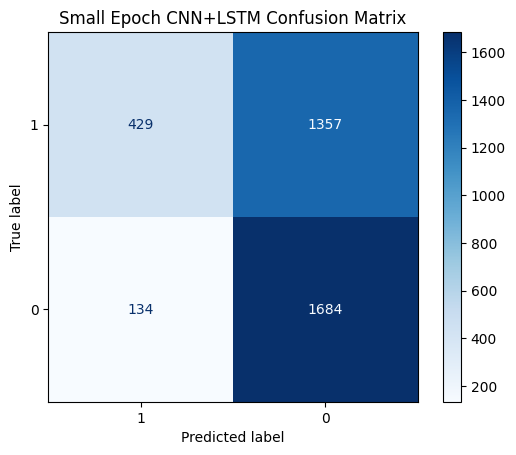

In [71]:
results = model.evaluate(testFeatures,testLabels)
print("test loss, test accuracy", results)

y_pred = tf.argmax(model.predict(testFeatures), axis=1)
print("F1_Score:",f1_score(testLabels, y_pred, average='macro'))

confuse(testFeatures,testLabels,'Small Epoch CNN+LSTM')